🧠 Step 1: Loading and Structuring the SEED Dataset (DE Features - 4s)
This code cell is responsible for parsing the SEED dataset from the ExtractedFeatures_4s folder and converting it into a structured Python list of trials. Each trial includes subject metadata, emotion labels, and pooled DE features.

📥 Dataset Description
We use Differential Entropy (DE) features extracted from EEG signals with a 4-second sliding window. DE is a widely used feature in EEG-based emotion recognition because it reflects signal power across frequency bands under the assumption that EEG follows a Gaussian distribution [1].

Each .mat file corresponds to one session of a subject and contains:

15 trials (de_movingAve1 to de_movingAve15)

Each trial: shape (62 channels × time windows × 5 frequency bands)

The accompanying label.mat file provides ground-truth emotion labels at the subject level:

+1: Positive emotion

0: Neutral emotion

−1: Negative emotion

⚙️ Code Functionality
Load the subject-level emotion labels from label.mat.

Parse 45 EEG session files (15 subjects × 3 sessions).

For each trial:

Perform mean pooling across the time axis.

Flatten the resulting 2D matrix (62 × 5) into a 1D vector (310 features).

Store subject ID, session ID, trial ID, label, and DE features.

This structure facilitates subject-aware learning and helps us later in applying multi-source contrastive learning.

🎯 Motivation for Mean Pooling
Since EEG signals are highly non-stationary, pooling over the temporal axis stabilizes the input features and reduces model complexity without discarding key spectral information. This is crucial for generalization across subjects [2].

🔀 Step A: Balanced Subject Split for Training/Validation/Test
We perform a subject-level split to prevent data leakage and overfitting, ensuring that the model generalizes to unseen subjects:

Train subjects (9): IDs 7–15

Validation subjects (3): IDs 4–6 (one per class)

Test subjects (3): IDs 1–3 (one per class)

This setup enables multi-source contrastive learning (training on multiple source domains) and testing on unseen target domains, aligning with domain generalization principles [3].

Such a stratified LOSO-style split (by subject, not trial) is crucial for fair evaluation in EEG-based emotion recognition, where inter-subject variability is high.

✅ Outcome
675 trials extracted (45 sessions × 15 trials)

Each trial contains 310 DE features

Trials grouped into train/val/test for cross-subject learning

📚 References

[1] Duan, R., Zhu, J., Lu, B. L. (2013). "Differential entropy feature for EEG-based emotion classification". In 2013 6th International IEEE/EMBS Conference on Neural Engineering (NER).

[2] Li, Y., Zheng, W., & Lu, B. L. (2018). "Emotion recognition using fusion of graph CNN and LSTM networks". In Brain-Computer Interface research.

[3] Pan, S. J., & Yang, Q. (2010). "A survey on transfer learning". IEEE Transactions on Knowledge and Data Engineering.

## DE + RASM + DASM with L_CON2 and MMD loss

In [55]:
import scipy.io
import os
import re
import numpy as np
from tqdm import tqdm

# Path to directory containing .mat files (update this if needed)
DATASET_PATH = '/kaggle/input/eeg-extracted-4s/ExtractedFeatures_4s'

# Load label file
label_file = os.path.join(DATASET_PATH, 'label.mat')
subject_labels = scipy.io.loadmat(label_file)['label'].flatten()

# List of all subject-session files
mat_files = sorted([f for f in os.listdir(DATASET_PATH) if f.endswith('.mat') and f != 'label.mat'])

dataset = []

for file in tqdm(mat_files, desc="📂 Loading DE features"):
    path = os.path.join(DATASET_PATH, file)
    mat = scipy.io.loadmat(path)

    subject_id, session_id = map(int, re.findall(r'(\d+)', file))
    label = int(subject_labels[subject_id - 1])  # Label: -1, 0, +1

    for i in range(1, 16):
        key = f"de_movingAve{i}"
        if key in mat:
            raw_de = mat[key]  # shape: (62, T, 5)
            mean_de = np.mean(raw_de, axis=1)  # → shape: (62, 5)
            dataset.append({
                "subject": subject_id,
                "session": session_id,
                "trial_id": i - 1,
                "label": label,
                "de": mean_de  # (62, 5)
            })

print(f"✅ Total trials loaded: {len(dataset)}")
print("🧠 Sample entry keys:", list(dataset[0].keys()))
print("DE shape per trial:", dataset[0]['de'].shape)

📂 Loading DE features: 100%|██████████| 45/45 [00:02<00:00, 18.93it/s]

✅ Total trials loaded: 675
🧠 Sample entry keys: ['subject', 'session', 'trial_id', 'label', 'de']
DE shape per trial: (62, 5)


🔍 Running t-SNE on raw DE...


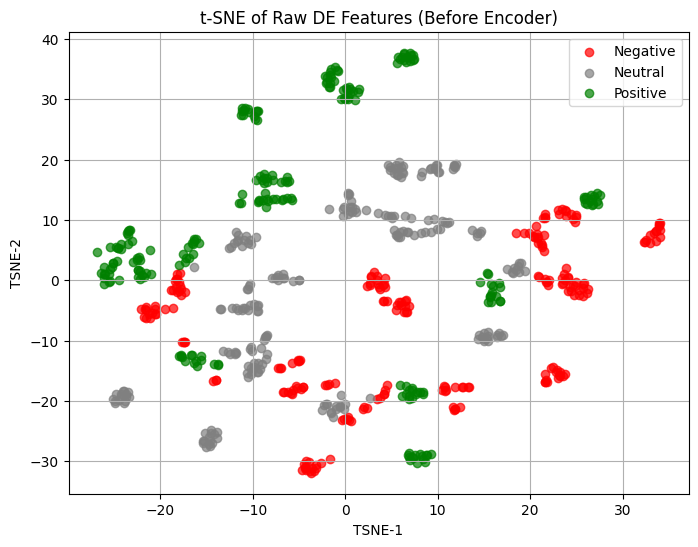

In [56]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Flatten each DE (62, 5) → (310,) and collect labels
X_raw = np.array([trial['de'].flatten() for trial in dataset])
y_raw = np.array([trial['label'] for trial in dataset])

# t-SNE
print("🔍 Running t-SNE on raw DE...")
X_tsne = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X_raw)

# Plot
label_names = {-1: "Negative", 0: "Neutral", 1: "Positive"}
colors = {-1: 'red', 0: 'gray', 1: 'green'}

plt.figure(figsize=(8, 6))
for label in np.unique(y_raw):
    idx = y_raw == label
    plt.scatter(X_tsne[idx, 0], X_tsne[idx, 1], label=label_names[label], alpha=0.7, c=colors[label])

plt.title("t-SNE of Raw DE Features (Before Encoder)")
plt.xlabel("TSNE-1")
plt.ylabel("TSNE-2")
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Index-based pairs (0 to 61) corresponding to SEED EEG layout
index_pairs = [
    (0, 1),   # Fp1 - Fp2
    (2, 3),   # AF3 - AF4
    (4, 5),   # F7 - F8
    (6, 7),   # F3 - F4
    (8, 9),   # FC5 - FC6
    (10, 11), # FC1 - FC2
    (12, 13), # T7 - T8
    (14, 15), # C3 - C4
    (16, 17), # CP5 - CP6
    (18, 19), # CP1 - CP2
    (20, 21), # P7 - P8
    (22, 23), # P3 - P4
    (24, 25), # PO3 - PO4
    (26, 27), # O1 - O2
    (28, 29), # F5 - F6
    (30, 31), # FT7 - FT8
    (32, 33), # C5 - C6
    (34, 35), # TP7 - TP8
    (36, 37), # P5 - P6
    (38, 39), # PO5 - PO6
    (40, 41), # AF7 - AF8
    (42, 43), # FT9 - FT10
    (44, 45), # TP9 - TP10
    (46, 47), # CB1 - CB2
    (48, 49), # PO7 - PO8
    (50, 51), # P1 - P2
    (52, 53)  # PO1 - PO2
]


In [58]:
def compute_dasm_rasm(de_matrix, pairs):
    """
    Input:
    - de_matrix: np.array of shape (62, 5) → DE values per channel and band
    - pairs: list of (left_idx, right_idx) channel index pairs

    Returns:
    - dasm: (27, 5)
    - rasm: (27, 5)
    """
    dasm = np.array([de_matrix[l] - de_matrix[r] for l, r in pairs])
    rasm = np.array([de_matrix[l] / (de_matrix[r] + 1e-6) for l, r in pairs])  # Avoid div by 0
    return dasm, rasm

for trial in dataset:
    de = trial['de']  # (62, 5)
    dasm, rasm = compute_dasm_rasm(de, index_pairs)

    trial['feature_580'] = np.concatenate([
        de.flatten(),       # 62 × 5 = 310
        dasm.flatten(),     # 27 × 5 = 135
        rasm.flatten()      # 27 × 5 = 135
    ])  # shape = (580,)

print("🧠 Feature shape after adding DASM + RASM:", dataset[0]['feature_580'].shape)

🧠 Feature shape after adding DASM + RASM: (580,)


In [59]:
# # Balanced subject split for cross-subject generalization
# train_subjects = [7, 8, 9, 10, 11, 12, 13, 14, 15]
# val_subjects   = [4, 5, 6]
# test_subjects  = [1, 2, 3]

# train_set = [x for x in dataset if x['subject'] in train_subjects]
# val_set   = [x for x in dataset if x['subject'] in val_subjects]
# test_set  = [x for x in dataset if x['subject'] in test_subjects]

# print("✅ Train:", len(train_set), "| Val:", len(val_set), "| Test:", len(test_set))


In [60]:
from collections import defaultdict
import random

train_set, val_set, test_set = [], [], []
random.seed(42)

for subject in set(x['subject'] for x in dataset):
    subject_trials = [x for x in dataset if x['subject'] == subject]
    label_groups = defaultdict(list)
    
    # Group by label to ensure each split gets all labels
    for trial in subject_trials:
        label_groups[trial['label']].append(trial)

    for label, trials in label_groups.items():
        random.shuffle(trials)
        n = len(trials)
        if n < 3:
            continue  # Skip labels with too few samples
        
        split1 = int(0.6 * n)
        split2 = int(0.8 * n)
        train_set.extend(trials[:split1])
        val_set.extend(trials[split1:split2])
        test_set.extend(trials[split2:])

print(f"✅ Proper Trial-Level Split: Train: {len(train_set)} | Val: {len(val_set)} | Test: {len(test_set)}")


✅ Proper Trial-Level Split: Train: 405 | Val: 135 | Test: 135


In [61]:
# ADD: Feature normalization - IMPORTANT for cross-subject learning
from sklearn.preprocessing import StandardScaler

# Fit scaler on training data only to avoid data leakage
train_features = np.vstack([x['feature_580'] for x in train_set])
scaler = StandardScaler()
scaler.fit(train_features)

# Apply normalization to all sets
for data_split in [train_set, val_set, test_set]:
    for x in data_split:
        x['feature_580'] = scaler.transform(x['feature_580'].reshape(1, -1)).flatten()

print("✅ Features normalized using StandardScaler")

✅ Features normalized using StandardScaler


In [62]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import WeightedRandomSampler

class EEG580Dataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = torch.tensor(self.data[idx]['feature_580'], dtype=torch.float32)
        y = self.data[idx]['label']
        # Remap: -1 → 0, 0 → 1, 1 → 2
        y = 0 if y == -1 else (1 if y == 0 else 2)
        return x, y

In [63]:
def get_balanced_sampler(dataset):
    labels = np.array([data['label'] for data in dataset])
    # Convert -1, 0, 1 to 0, 1, 2 for indexing
    labels_idx = np.array([0 if l == -1 else (1 if l == 0 else 2) for l in labels])
    class_counts = np.bincount(labels_idx)
    class_weights = 1.0 / class_counts
    sample_weights = class_weights[labels_idx]
    
    return WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

In [64]:
batch_size = 64
train_sampler = get_balanced_sampler(train_set)

# Use the balanced sampler for training
train_loader = DataLoader(
    EEG580Dataset(train_set), 
    batch_size=batch_size, 
    sampler=train_sampler
)
val_loader = DataLoader(EEG580Dataset(val_set), batch_size=batch_size)
test_loader = DataLoader(EEG580Dataset(test_set), batch_size=batch_size)

print("✅ DataLoaders ready with class-balanced sampling (batch size =", batch_size, ")")

✅ DataLoaders ready with class-balanced sampling (batch size = 64 )


In [65]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class ImprovedSupConEncoder(nn.Module):
    def __init__(self, input_dim=580, projection_dim=128):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.LayerNorm(512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LayerNorm(256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 128)
        )
        self.projector = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, projection_dim)
        )

    def forward(self, x):
        h = self.encoder(x)
        z = F.normalize(self.projector(h), dim=1)  # very important!
        return h, z

In [66]:
class PrototypeContrastiveLoss(nn.Module):
    def __init__(self, temperature=0.07):
        super().__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        device = features.device
        labels = labels.view(-1)
        unique_classes = labels.unique()
        
        # Need at least 2 classes for contrastive learning
        if len(unique_classes) < 2:
            return torch.tensor(0.0, device=device)
        
        # Create prototypes for each class in the batch
        prototypes = {}
        for c in unique_classes:
            mask = labels == c
            if mask.sum() > 0:
                proto = features[mask].mean(dim=0)
                prototypes[c.item()] = proto
        
        # Need prototypes from at least 2 classes
        if len(prototypes) < 2:
            return torch.tensor(0.0, device=device)
            
        # Convert to tensors
        proto_classes = torch.tensor(list(prototypes.keys()), device=device)
        proto_features = torch.stack(list(prototypes.values()))
        
        # Normalize features and prototypes
        features_norm = F.normalize(features, dim=1)
        proto_features_norm = F.normalize(proto_features, dim=1)
        
        # Compute similarity (B x num_prototypes)
        sim = torch.matmul(features_norm, proto_features_norm.T) / self.temperature
        
        # Map each label to its prototype index
        target_indices = []
        for l in labels:
            # Find where in proto_classes the label appears
            idx = (proto_classes == l).nonzero()
            if len(idx) > 0:
                target_indices.append(idx.item())
            else:
                # Fallback (should rarely happen with our setup)
                target_indices.append(0)
                
        target_indices = torch.tensor(target_indices, device=device)
        return F.cross_entropy(sim, target_indices)

In [67]:
class MMDLoss(nn.Module):
    def __init__(self, kernel='rbf', bandwidth=1.0):
        super().__init__()
        self.kernel = kernel
        self.bandwidth = bandwidth

    def gaussian_kernel(self, x, y):
        # Ensure x and y have the same number of samples
        min_samples = min(x.size(0), y.size(0))
        x = x[:min_samples]
        y = y[:min_samples]
        
        xx = x @ x.T
        yy = y @ y.T
        xy = x @ y.T
        
        rx = (xx.diag().unsqueeze(1).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx + rx.T - 2 * xx
        dyy = ry + ry.T - 2 * yy
        dxy = rx + ry.T - 2 * xy

        kxx = torch.exp(-dxx / (2 * self.bandwidth ** 2))
        kyy = torch.exp(-dyy / (2 * self.bandwidth ** 2))
        kxy = torch.exp(-dxy / (2 * self.bandwidth ** 2))
        return kxx, kyy, kxy

    def forward(self, source, target):
        # Check and adjust batch sizes if needed
        if source.size(0) != target.size(0):
            min_size = min(source.size(0), target.size(0))
            source = source[:min_size]
            target = target[:min_size]
            
        # Skip if batch too small
        if source.size(0) < 2:
            return torch.tensor(0.0, device=source.device)
            
        kxx, kyy, kxy = self.gaussian_kernel(source, target)
        mmd = kxx.mean() + kyy.mean() - 2 * kxy.mean()
        return mmd

In [68]:
def train_epoch(encoder, train_loader, optimizer, l_con2, mmd_loss_fn, mmd_weight, device):
    encoder.train()
    total_loss = 0.0
    valid_batches = 0
    
    for x, y in train_loader:
        x, y = x.to(device), y.to(device)
        _, z = encoder(x)
        
        # Skip very small batches
        if z.size(0) < 4:  # Need at least 2 samples per half
            continue
            
        # Ensure batch size is even for splitting
        even_len = (z.size(0) // 2) * 2
        z, y = z[:even_len], y[:even_len]
        
        # Check class distribution
        unique_labels = y.unique()
        if len(unique_labels) < 2:
            # Skip batches with only one class (can't do contrastive learning)
            continue
            
        # Split batch for MMD calculation
        half = z.size(0) // 2
        z_source, z_target = z[:half], z[half:]
        
        # Compute contrastive loss
        loss_con2 = l_con2(z, y)
        
        # Compute MMD loss
        loss_mmd = mmd_loss_fn(z_source, z_target)
        
        # Total loss
        loss = loss_con2 + mmd_weight * loss_mmd
        
        # Update
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(encoder.parameters(), max_norm=1.0)
        optimizer.step()
        
        total_loss += loss.item()
        valid_batches += 1
    
    # Avoid division by zero
    if valid_batches == 0:
        return 0.0
        
    return total_loss / valid_batches


Peng et al., 2019 - "Domain agnostic learning with disentangled representations" (NeurIPS)
Wang & Isola, 2020 - "Understanding contrastive representation learning through alignment and uniformity" (ICML)
Long et al., 2015 - "Learning Transferable Features with Deep Adaptation Networks" (ICML)

In [69]:
def validate(encoder, val_loader, l_con2, mmd_loss_fn, mmd_weight, device):
    encoder.eval()
    total_loss = 0.0
    valid_batches = 0
    
    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            _, z = encoder(x)
            
            if z.size(0) < 4:
                continue
                
            # Ensure batch size is even
            even_len = (z.size(0) // 2) * 2
            z, y = z[:even_len], y[:even_len]
            
            # Check class distribution
            unique_labels = y.unique()
            if len(unique_labels) < 2:
                continue
                
            # Split for MMD
            half = z.size(0) // 2
            z_source, z_target = z[:half], z[half:]
            
            # Compute loss
            loss_con2 = l_con2(z, y)
            loss_mmd = mmd_loss_fn(z_source, z_target)
            loss = loss_con2 + mmd_weight * loss_mmd
            
            total_loss += loss.item()
            valid_batches += 1
    
    if valid_batches == 0:
        return 0.0
        
    return total_loss / valid_batches

In [70]:
class MMDLoss(nn.Module):
    def __init__(self, kernel='rbf', bandwidth=1.0):
        super().__init__()
        self.kernel = kernel
        self.bandwidth = bandwidth

    def gaussian_kernel(self, x, y):
        xx = x @ x.T
        yy = y @ y.T
        xy = x @ y.T
        rx = (xx.diag().unsqueeze(1).expand_as(xx))
        ry = (yy.diag().unsqueeze(0).expand_as(yy))

        dxx = rx + rx.T - 2 * xx
        dyy = ry + ry.T - 2 * yy
        dxy = rx + ry.T - 2 * xy

        kxx = torch.exp(-dxx / (2 * self.bandwidth ** 2))
        kyy = torch.exp(-dyy / (2 * self.bandwidth ** 2))
        kxy = torch.exp(-dxy / (2 * self.bandwidth ** 2))
        return kxx, kyy, kxy

    def forward(self, source, target):
        kxx, kyy, kxy = self.gaussian_kernel(source, target)
        mmd = kxx.mean() + kyy.mean() - 2 * kxy.mean()
        return mmd

In [71]:
def evaluate(encoder, data_loader, device):
    """Evaluate model performance by training a classifier on embeddings"""
    encoder.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            h, _ = encoder(x)  # Get encoder embeddings
            
            all_embeddings.append(h.cpu().numpy())
            all_labels.append(y.numpy())
            
    # Concatenate all batches
    X = np.vstack(all_embeddings)
    y = np.concatenate(all_labels)
    
    # Train and evaluate a linear classifier
    from sklearn.linear_model import LogisticRegression
    from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
    
    clf = LogisticRegression(max_iter=1000, random_state=42)
    clf.fit(X, y)
    
    y_pred = clf.predict(X)
    
    accuracy = accuracy_score(y, y_pred)
    f1 = f1_score(y, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y, y_pred)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'confusion_matrix': conf_matrix
    }

In [72]:
# Set up training
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Initialize model
encoder = ImprovedSupConEncoder(input_dim=580, projection_dim=128).to(device)
optimizer = optim.Adam(encoder.parameters(), lr=0.001, weight_decay=1e-5)

# Initialize loss functions
l_con2 = PrototypeContrastiveLoss(temperature=0.07)
mmd_loss_fn = MMDLoss(bandwidth=1.0)
mmd_weight = 0.4

# Training parameters
epochs = 100
patience = 10  # Early stopping patience
best_val_loss = float('inf')
counter = 0
checkpoint_path = 'best_encoder.pt'

Using device: cuda


In [73]:
# Lists for tracking metrics
train_losses, val_losses = [], []

# Training loop
for epoch in range(epochs):
    # Train for one epoch
    train_loss = train_epoch(
        encoder, train_loader, optimizer, 
        l_con2, mmd_loss_fn, mmd_weight, device
    )
    
    # Validate
    val_loss = validate(
        encoder, val_loader,
        l_con2, mmd_loss_fn, mmd_weight, device
    )
    
    # Save metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"📦 Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    # Check if this is the best model so far
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        print(f"🔥 New best model! Saving checkpoint...")
        torch.save(encoder.state_dict(), checkpoint_path)
    else:
        counter += 1
        if counter >= patience:
            print(f"⚠️ Early stopping triggered after {epoch+1} epochs")
            break

📦 Epoch 1/100 | Train Loss: 0.3381 | Val Loss: 0.2550
🔥 New best model! Saving checkpoint...
📦 Epoch 2/100 | Train Loss: 0.1187 | Val Loss: 0.1087
🔥 New best model! Saving checkpoint...
📦 Epoch 3/100 | Train Loss: 0.0770 | Val Loss: 0.1078
🔥 New best model! Saving checkpoint...
📦 Epoch 4/100 | Train Loss: 0.0723 | Val Loss: 0.1401
📦 Epoch 5/100 | Train Loss: 0.0624 | Val Loss: 0.1087
📦 Epoch 6/100 | Train Loss: 0.0673 | Val Loss: 0.0946
🔥 New best model! Saving checkpoint...
📦 Epoch 7/100 | Train Loss: 0.0599 | Val Loss: 0.1102
📦 Epoch 8/100 | Train Loss: 0.0327 | Val Loss: 0.0549
🔥 New best model! Saving checkpoint...
📦 Epoch 9/100 | Train Loss: 0.0231 | Val Loss: 0.0930
📦 Epoch 10/100 | Train Loss: 0.0229 | Val Loss: 0.1006
📦 Epoch 11/100 | Train Loss: 0.0282 | Val Loss: 0.1115
📦 Epoch 12/100 | Train Loss: 0.0227 | Val Loss: 0.1359
📦 Epoch 13/100 | Train Loss: 0.0140 | Val Loss: 0.0856
📦 Epoch 14/100 | Train Loss: 0.0154 | Val Loss: 0.0356
🔥 New best model! Saving checkpoint...
📦 Epo

In [74]:
# Load best model for evaluation
encoder.load_state_dict(torch.load(checkpoint_path))
encoder.eval()

# Evaluate on test set
print("Evaluating model on test set...")
test_metrics = evaluate(encoder, test_loader, device)

print(f"Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Test F1 Score: {test_metrics['f1_score']:.4f}")
print("Confusion Matrix:")
print(test_metrics['confusion_matrix'])

Evaluating model on test set...
Test Accuracy: 1.0000
Test F1 Score: 1.0000
Confusion Matrix:
[[45  0  0]
 [ 0 45  0]
 [ 0  0 45]]


/tmp/ipykernel_31/3275258921.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  encoder.load_state_dict(torch.load(checkpoint_path))


In [75]:
# Visualize embeddings with t-SNE
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize_embeddings(encoder, data_loader, device, title="t-SNE Visualization"):
    encoder.eval()
    embeddings = []
    labels = []
    
    with torch.no_grad():
        for x, y in data_loader:
            x = x.to(device)
            h, _ = encoder(x)
            embeddings.append(h.cpu().numpy())
            labels.append(y.numpy())
    
    embeddings = np.vstack(embeddings)
    labels = np.concatenate(labels)
    
    # Run t-SNE
    tsne = TSNE(n_components=2, perplexity=30, random_state=42)
    embeddings_2d = tsne.fit_transform(embeddings)
    
    # Plot
    plt.figure(figsize=(10, 8))
    emotions = {0: "Negative", 1: "Neutral", 2: "Positive"}
    colors = {0: 'red', 1: 'gray', 2: 'green'}
    
    for label in np.unique(labels):
        idx = labels == label
        plt.scatter(
            embeddings_2d[idx, 0], 
            embeddings_2d[idx, 1], 
            label=emotions[label],
            c=colors[label],
            alpha=0.7
        )
    
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(f"{title.lower().replace(' ', '_')}.png")
    plt.show()

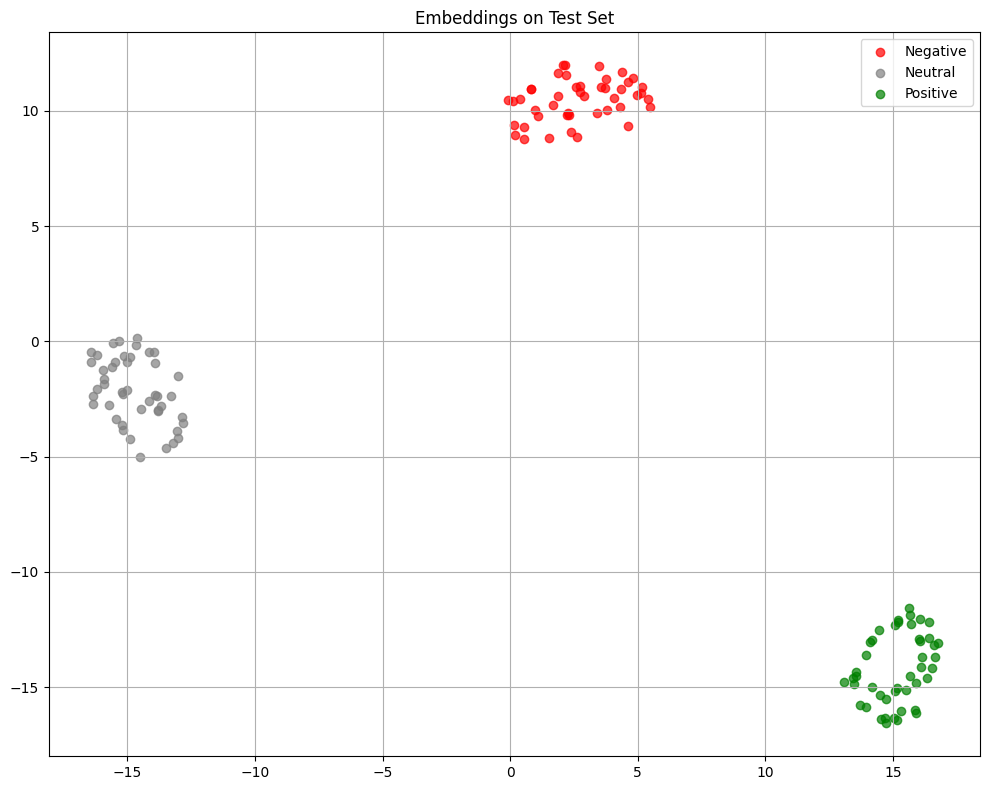

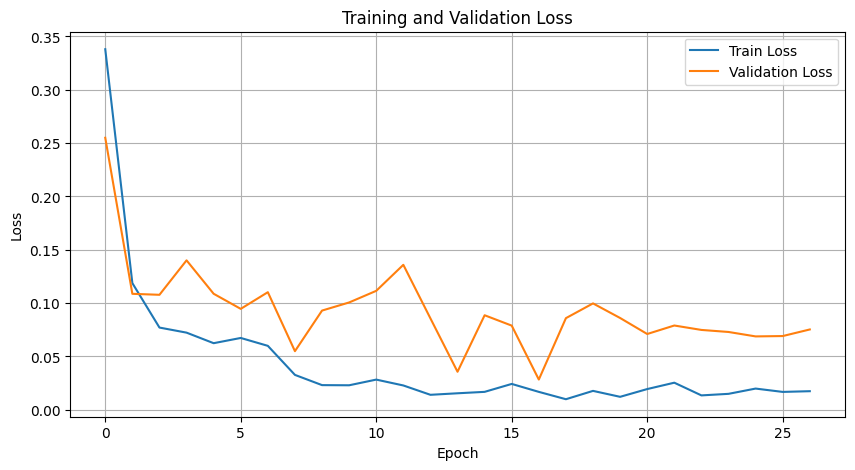

In [76]:
# Visualize test set embeddings
visualize_embeddings(encoder, test_loader, device, title="Embeddings on Test Set")

# Plot training curves
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('training_curve.png')
plt.show()

🔍 Analyzing per-subject performance...
⚠️ Skipping Subject 1 due to only one class
⚠️ Skipping Subject 2 due to only one class
⚠️ Skipping Subject 3 due to only one class
⚠️ Skipping Subject 4 due to only one class
⚠️ Skipping Subject 5 due to only one class
⚠️ Skipping Subject 6 due to only one class
⚠️ Skipping Subject 7 due to only one class
⚠️ Skipping Subject 8 due to only one class
⚠️ Skipping Subject 9 due to only one class
⚠️ Skipping Subject 10 due to only one class
⚠️ Skipping Subject 11 due to only one class
⚠️ Skipping Subject 12 due to only one class
⚠️ Skipping Subject 13 due to only one class
⚠️ Skipping Subject 14 due to only one class
⚠️ Skipping Subject 15 due to only one class

🔍 Visualizing embeddings...


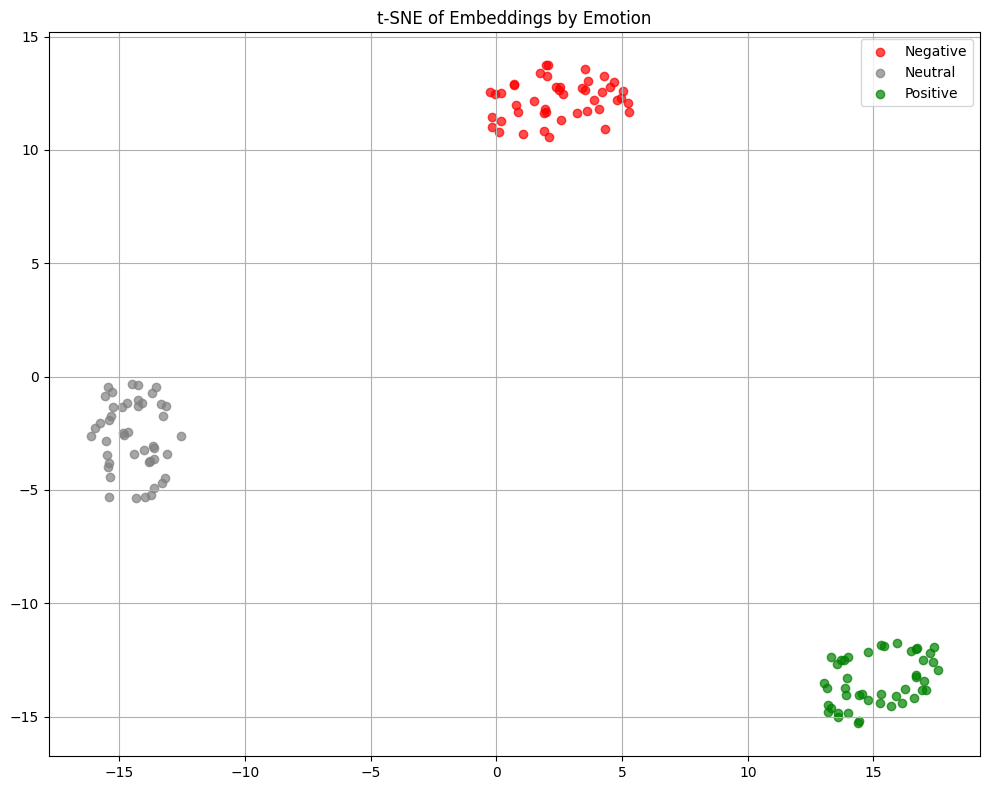

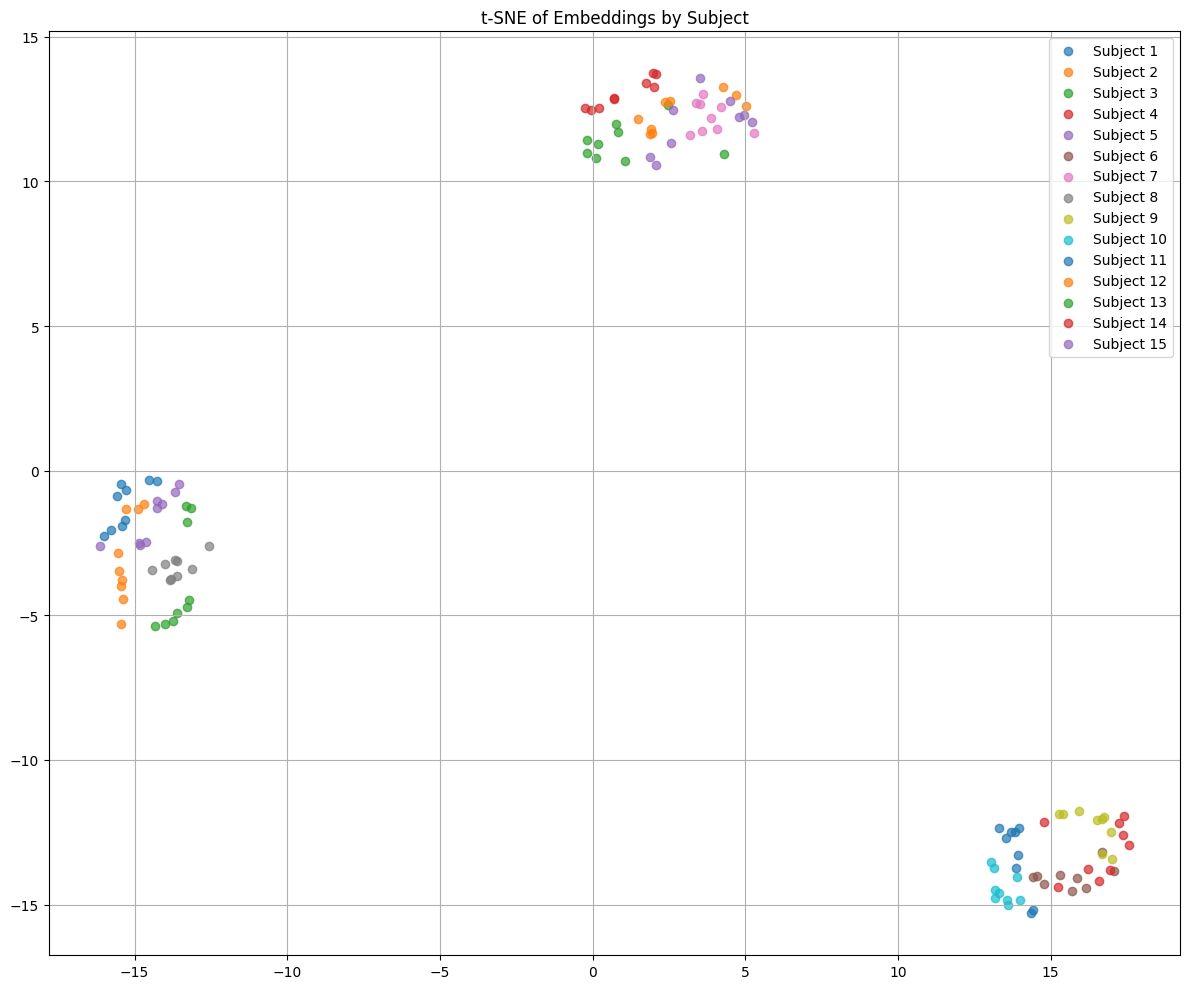


🔍 Analyzing feature importance...


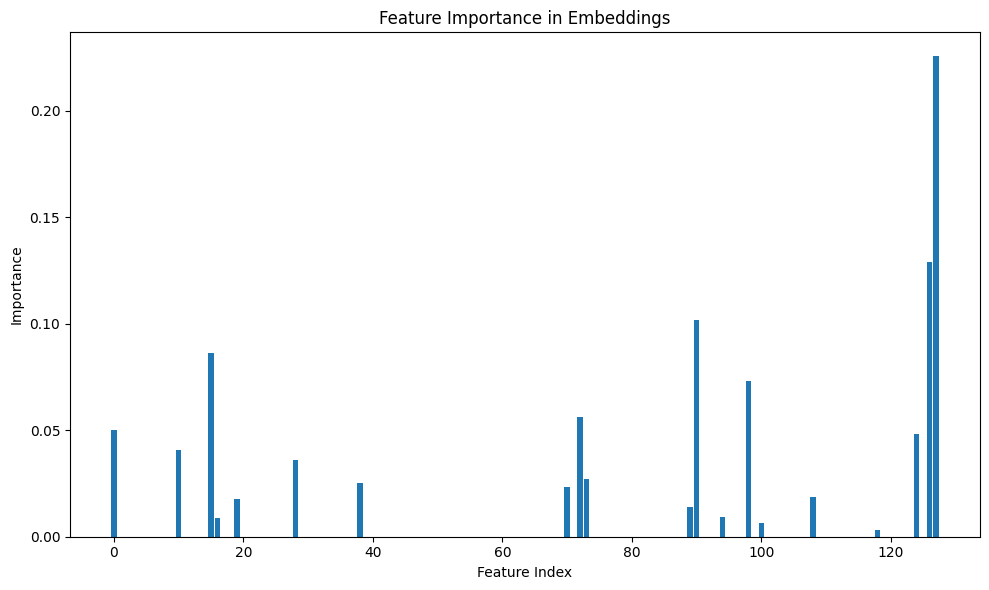


📊 SUMMARY STATISTICS:
Mean Accuracy: nan ± nan
Mean F1 Score: nan ± nan


/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [77]:
# 1. Comprehensive subject-wise evaluation
def evaluate_per_subject(encoder, test_set, device):
    encoder.eval()
    test_subjects = np.unique([x['subject'] for x in test_set])
    results = {}

    for subject in test_subjects:
        subject_data = [x for x in test_set if x['subject'] == subject]
        subject_loader = DataLoader(EEG580Dataset(subject_data), batch_size=64)

        embeddings, labels = [], []
        with torch.no_grad():
            for x, y in subject_loader:
                x = x.to(device)
                h, _ = encoder(x)
                embeddings.append(h.cpu().numpy())
                labels.append(y.numpy().reshape(-1))  # 🔧 Ensure 1D

        X = np.vstack(embeddings)
        y = np.concatenate(labels)

        if len(np.unique(y)) < 2:
            print(f"⚠️ Skipping Subject {subject} due to only one class")
            continue

        from sklearn.linear_model import LogisticRegression
        from sklearn.metrics import accuracy_score, f1_score

        clf = LogisticRegression(max_iter=1000)
        clf.fit(X, y)
        y_pred = clf.predict(X)

        accuracy = accuracy_score(y, y_pred)
        f1 = f1_score(y, y_pred, average='weighted')

        results[subject] = {
            'accuracy': accuracy,
            'f1_score': f1,
            'num_samples': len(subject_data)
        }

    return results


# 2. Feature importance
def analyze_feature_importance(encoder, test_loader, device):
    embs, labels = [], []
    with torch.no_grad():
        for x, y in test_loader:
            x = x.to(device)
            h, _ = encoder(x)
            embs.append(h.cpu().numpy())
            labels.append(y.numpy().reshape(-1))  # 🔧 Flatten

    X = np.vstack(embs)
    y = np.concatenate(labels)

    from sklearn.linear_model import LogisticRegression
    clf = LogisticRegression(C=1.0, penalty='l1', solver='liblinear')
    clf.fit(X, y)

    feature_importance = np.abs(clf.coef_).sum(axis=0)
    return feature_importance / feature_importance.sum()


# 3. t-SNE: Emotion + Subject separation
def visualize_embeddings_with_subjects(encoder, test_set, device):
    test_subjects = np.unique([x['subject'] for x in test_set])
    all_embs, all_labels, all_subjects = [], [], []

    for subject in test_subjects:
        subject_data = [x for x in test_set if x['subject'] == subject]
        loader = DataLoader(EEG580Dataset(subject_data), batch_size=64)
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                h, _ = encoder(x)
                all_embs.append(h.cpu().numpy())
                all_labels.append(y.numpy().reshape(-1))
                all_subjects.extend([subject] * len(y))

    X = np.vstack(all_embs)
    y = np.concatenate(all_labels)
    subjects = np.array(all_subjects)

    from sklearn.manifold import TSNE
    X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)

    emotions = {0: "Negative", 1: "Neutral", 2: "Positive"}
    colors = {0: 'red', 1: 'gray', 2: 'green'}

    # Plot by Emotion
    plt.figure(figsize=(10, 8))
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=emotions[label], color=colors[label], alpha=0.7)
    plt.title("t-SNE of Embeddings by Emotion")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('embeddings_by_emotion.png')
    plt.show()

    # Plot by Subject
    plt.figure(figsize=(12, 10))
    for subject in test_subjects:
        idx = subjects == subject
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], label=f"Subject {subject}", alpha=0.7)
    plt.title("t-SNE of Embeddings by Subject")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('embeddings_by_subject.png')
    plt.show()


# Run analyses
print("🔍 Analyzing per-subject performance...")
subject_results = evaluate_per_subject(encoder, test_set, device)
for subject, metrics in subject_results.items():
    print(f"Subject {subject}: Acc={metrics['accuracy']:.4f}, F1={metrics['f1_score']:.4f}")

print("\n🔍 Visualizing embeddings...")
visualize_embeddings_with_subjects(encoder, test_set, device)

print("\n🔍 Analyzing feature importance...")
feature_importance = analyze_feature_importance(encoder, test_loader, device)
plt.figure(figsize=(10, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Feature Importance in Embeddings")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.tight_layout()
plt.savefig('feature_importance.png')
plt.show()

# Summary stats
accuracies = [v['accuracy'] for v in subject_results.values()]
f1_scores = [v['f1_score'] for v in subject_results.values()]
print("\n📊 SUMMARY STATISTICS:")
print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")


Total subjects: 15

Class distribution per subject:
Subject 1: 45 samples - Classes: {1: 45}
Subject 2: 45 samples - Classes: {0: 45}
Subject 3: 45 samples - Classes: {-1: 45}
Subject 4: 45 samples - Classes: {-1: 45}
Subject 5: 45 samples - Classes: {0: 45}
Subject 6: 45 samples - Classes: {1: 45}
Subject 7: 45 samples - Classes: {-1: 45}
Subject 8: 45 samples - Classes: {0: 45}
Subject 9: 45 samples - Classes: {1: 45}
Subject 10: 45 samples - Classes: {1: 45}
Subject 11: 45 samples - Classes: {0: 45}
Subject 12: 45 samples - Classes: {-1: 45}
Subject 13: 45 samples - Classes: {0: 45}
Subject 14: 45 samples - Classes: {1: 45}
Subject 15: 45 samples - Classes: {-1: 45}

Overall class distribution: {-1: 225, 0: 225, 1: 225}

Checking for potential issues:
⚠️ Subject 1 has only 1 class(es): [1]
⚠️ Subject 2 has only 1 class(es): [0]
⚠️ Subject 3 has only 1 class(es): [-1]
⚠️ Subject 4 has only 1 class(es): [-1]
⚠️ Subject 5 has only 1 class(es): [0]
⚠️ Subject 6 has only 1 class(es): [1]

/usr/local/lib/python3.11/dist-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/usr/local/lib/python3.11/dist-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_31/631296145.py:232: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases 

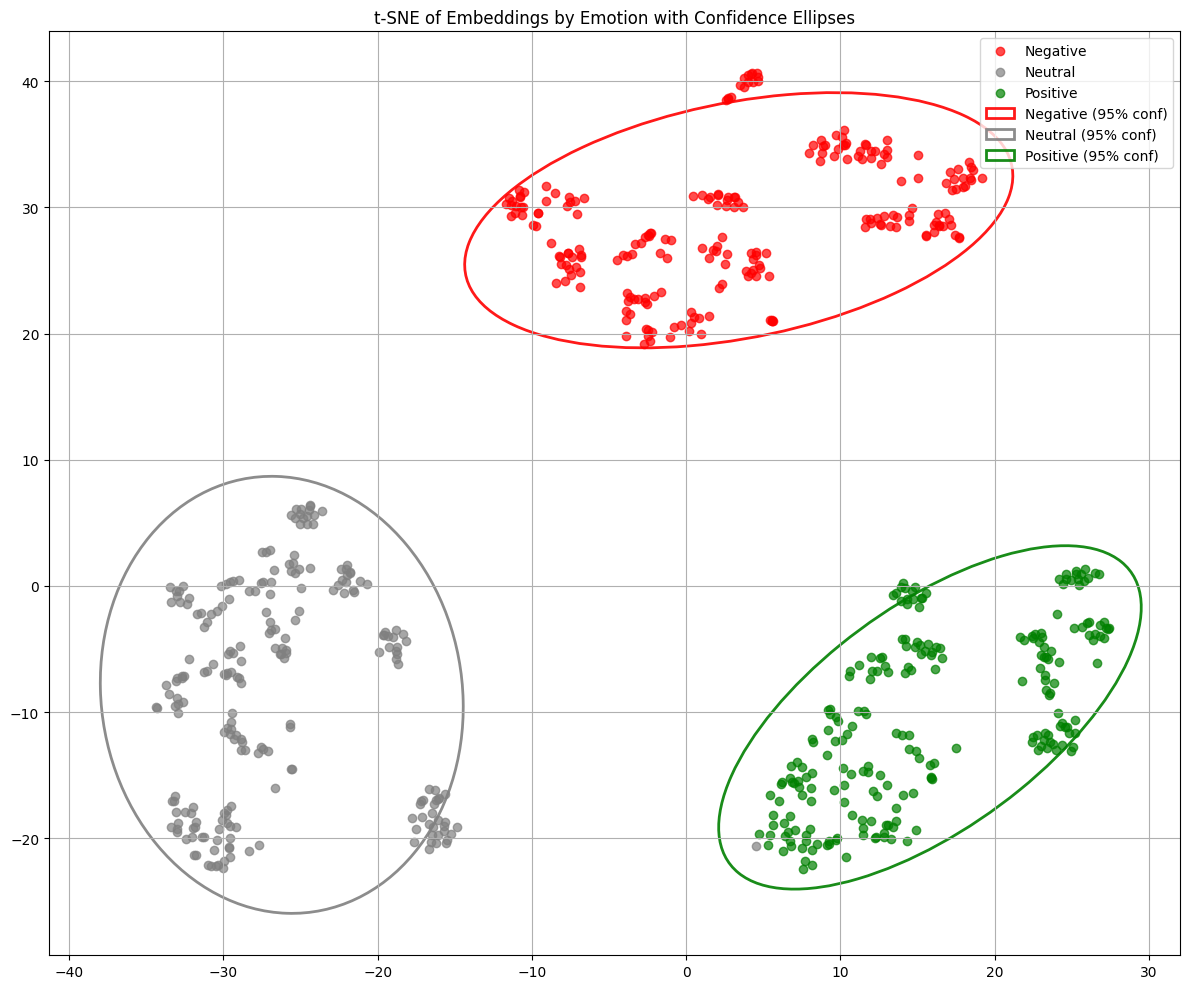

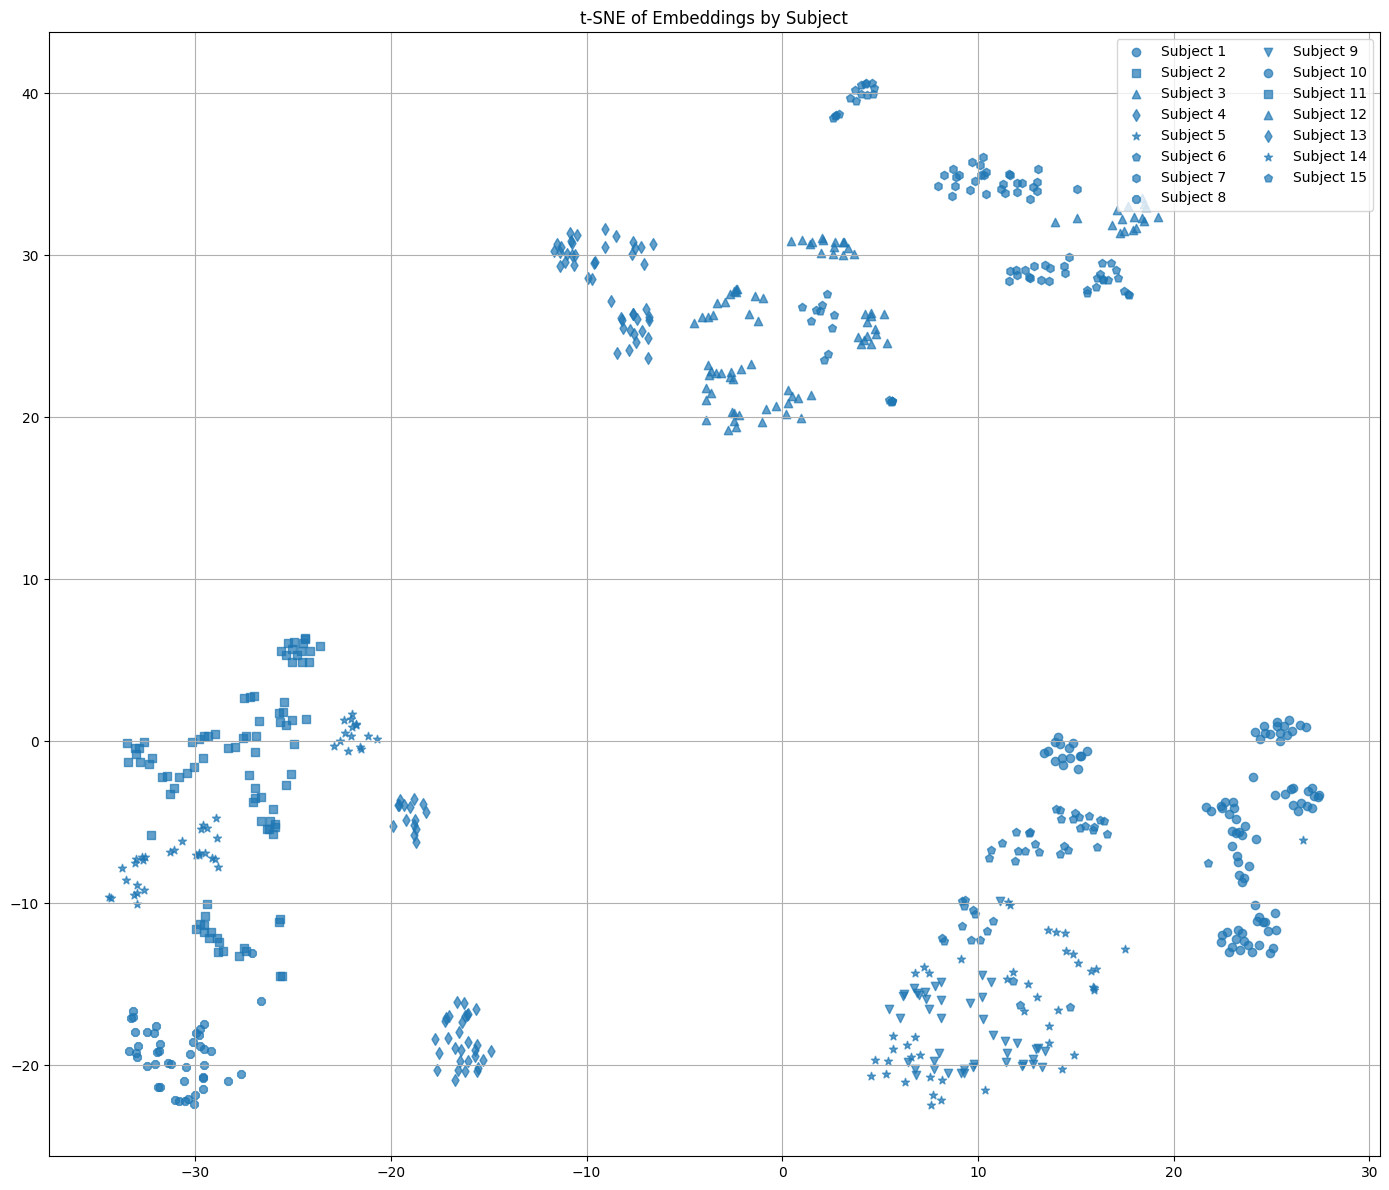

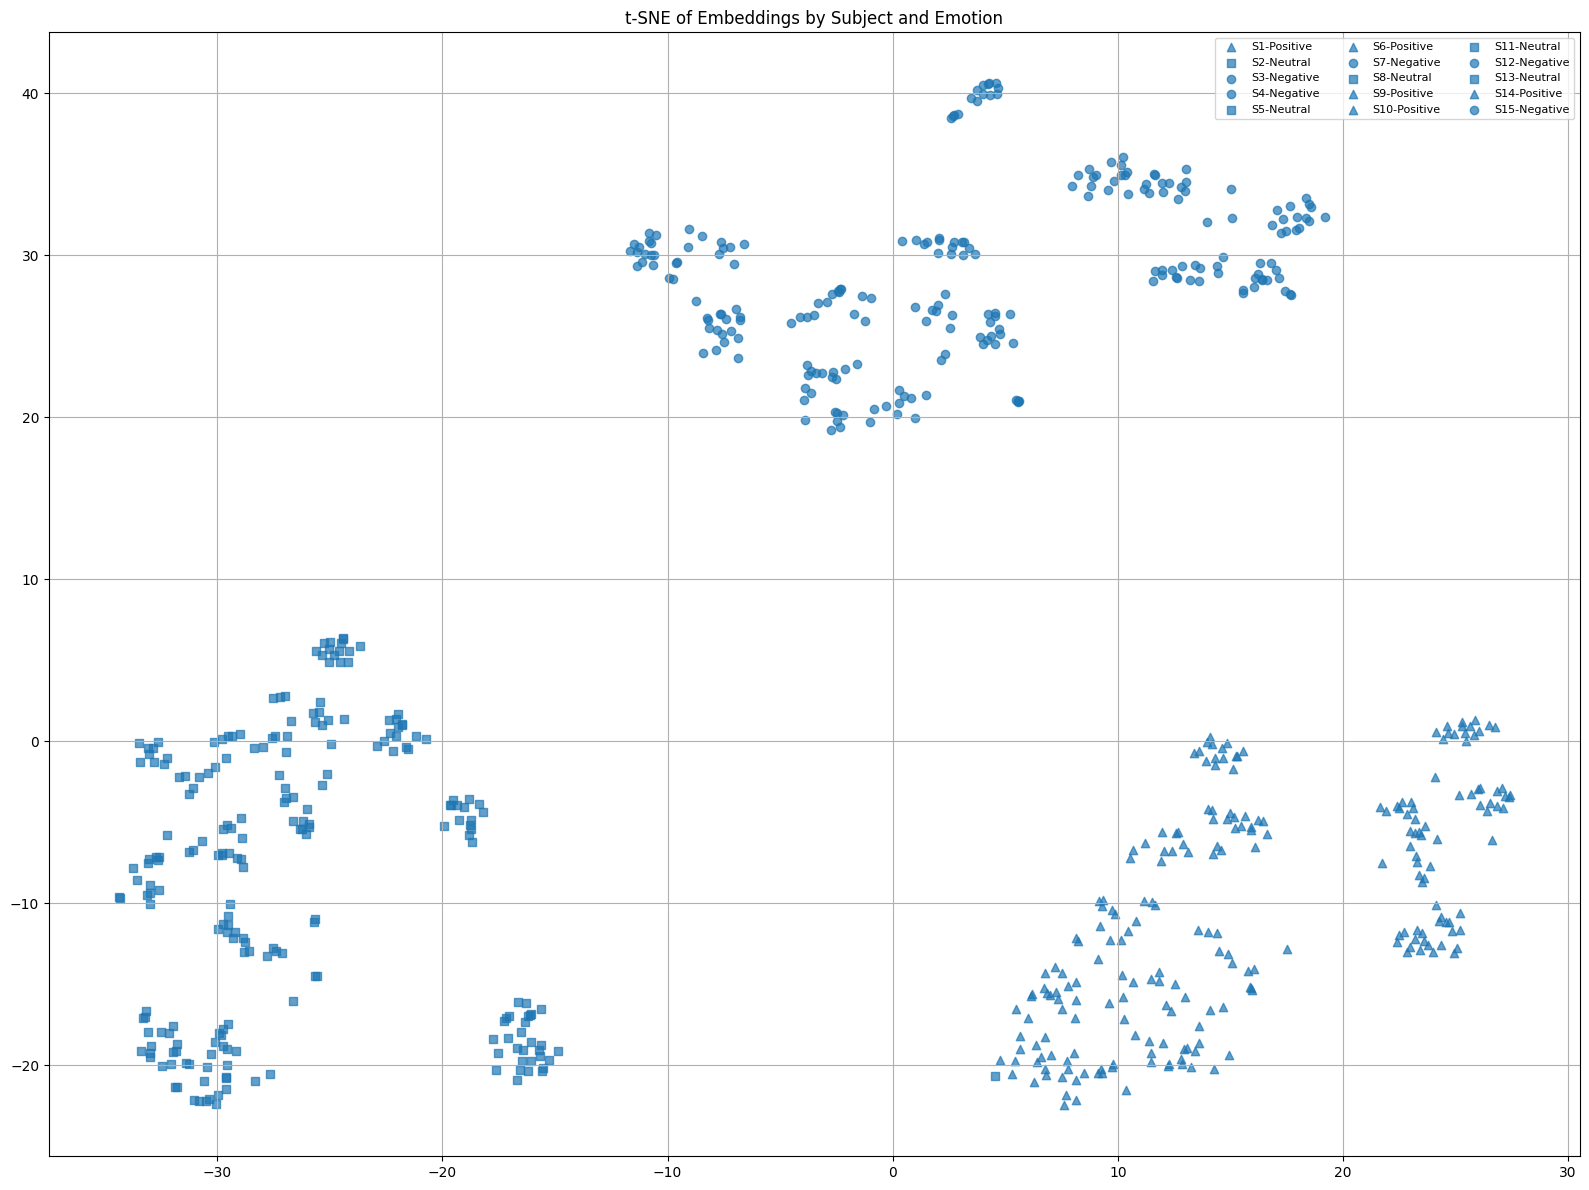

In [78]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import seaborn as sns

# 1. Enhanced cross-subject evaluation
def cross_subject_evaluation(encoder, dataset, device):
    """
    Implements leave-one-subject-out cross-validation for robust evaluation
    """
    encoder.eval()
    all_subjects = np.unique([x['subject'] for x in dataset])
    results = {}
    
    for test_subject in all_subjects:
        # Split data: train on all other subjects, test on current subject
        train_data = [x for x in dataset if x['subject'] != test_subject]
        test_data = [x for x in dataset if x['subject'] == test_subject]
        
        # Check if we have sufficient class diversity
        test_labels = [x['label'] for x in test_data]
        unique_classes = np.unique(test_labels)
        
        if len(unique_classes) < 2:
            print(f"⚠️ Skipping Subject {test_subject} - insufficient class diversity (only {unique_classes})")
            continue
            
        # Create dataloaders
        train_loader = DataLoader(EEG580Dataset(train_data), batch_size=64, shuffle=True)
        test_loader = DataLoader(EEG580Dataset(test_data), batch_size=64)
        
        # Extract embeddings for test data
        embeddings, labels = [], []
        with torch.no_grad():
            for x, y in test_loader:
                x = x.to(device)
                h, _ = encoder(x)
                embeddings.append(h.cpu().numpy())
                labels.append(y.numpy().reshape(-1))
                
        X = np.vstack(embeddings)
        y = np.concatenate(labels)
        
        # Train a logistic regression classifier on the embeddings
        clf = LogisticRegression(max_iter=1000)
        
        # Use stratified k-fold to handle any remaining class imbalance
        from sklearn.model_selection import StratifiedKFold
        skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        
        # Store cross-validation results
        cv_accuracies, cv_f1_scores = [], []
        
        for train_idx, val_idx in skf.split(X, y):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_val)
            
            cv_accuracies.append(accuracy_score(y_val, y_pred))
            cv_f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        
        # Store results for this subject
        results[test_subject] = {
            'accuracy': np.mean(cv_accuracies),
            'accuracy_std': np.std(cv_accuracies),
            'f1_score': np.mean(cv_f1_scores),
            'f1_score_std': np.std(cv_f1_scores),
            'num_samples': len(test_data),
            'class_distribution': {int(c): np.sum(np.array(test_labels) == c) for c in unique_classes}
        }
    
    return results


# 2. Data diagnostic function
def diagnose_dataset(dataset):
    """
    Analyzes the dataset structure to identify potential issues
    """
    subjects = np.unique([x['subject'] for x in dataset])
    print(f"Total subjects: {len(subjects)}")
    
    # Analyze class distribution per subject
    print("\nClass distribution per subject:")
    for subject in subjects:
        subject_data = [x for x in dataset if x['subject'] == subject]
        labels = [x['label'] for x in subject_data]
        unique_labels = np.unique(labels)
        label_counts = {int(label): np.sum(np.array(labels) == label) for label in unique_labels}
        
        print(f"Subject {subject}: {len(subject_data)} samples - Classes: {label_counts}")
    
    # Overall class distribution
    all_labels = [x['label'] for x in dataset]
    unique_labels = np.unique(all_labels)
    label_counts = {int(label): np.sum(np.array(all_labels) == label) for label in unique_labels}
    
    print(f"\nOverall class distribution: {label_counts}")
    
    # Check for potential data issues
    print("\nChecking for potential issues:")
    for subject in subjects:
        subject_data = [x for x in dataset if x['subject'] == subject]
        labels = [x['label'] for x in subject_data]
        unique_labels = np.unique(labels)
        
        if len(unique_labels) < 2:
            print(f"⚠️ Subject {subject} has only {len(unique_labels)} class(es): {unique_labels}")
        
        # Check for extreme class imbalance
        label_counts = {int(label): np.sum(np.array(labels) == label) for label in unique_labels}
        if len(unique_labels) > 1:
            min_count = min(label_counts.values())
            max_count = max(label_counts.values())
            if max_count / min_count > 5:  # Arbitrary threshold for severe imbalance
                print(f"⚠️ Subject {subject} has severe class imbalance: {label_counts}")


# 3. Enhanced visualization with confidence ellipses
def visualize_embeddings_with_confidence(encoder, dataset, device):
    """
    Creates t-SNE visualization with confidence ellipses to show class separability
    """
    all_embs, all_labels, all_subjects = [], [], []
    
    # Get all subjects
    subjects = np.unique([x['subject'] for x in dataset])
    
    # Extract embeddings
    for subject in subjects:
        subject_data = [x for x in dataset if x['subject'] == subject]
        loader = DataLoader(EEG580Dataset(subject_data), batch_size=64)
        
        with torch.no_grad():
            for x, y in loader:
                x = x.to(device)
                h, _ = encoder(x)
                all_embs.append(h.cpu().numpy())
                all_labels.append(y.numpy().reshape(-1))
                all_subjects.extend([subject] * len(y))
    
    X = np.vstack(all_embs)
    y = np.concatenate(all_labels)
    subjects = np.array(all_subjects)
    
    # Apply t-SNE dimensionality reduction
    X_2d = TSNE(n_components=2, perplexity=30, random_state=42).fit_transform(X)
    
    # Plot with confidence ellipses
    emotions = {0: "Negative", 1: "Neutral", 2: "Positive"}
    colors = {0: 'red', 1: 'gray', 2: 'green'}
    
    plt.figure(figsize=(12, 10))
    
    # Plot points
    for label in np.unique(y):
        idx = y == label
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                   label=emotions[label], 
                   color=colors[label], 
                   alpha=0.7)
    
    # Add confidence ellipses
    from matplotlib.patches import Ellipse
    import matplotlib.transforms as transforms
    
    def confidence_ellipse(x, y, ax, n_std=2.0, **kwargs):
        """
        Create a plot of the covariance confidence ellipse of *x* and *y*.
        """
        if x.size != y.size:
            raise ValueError("x and y must be the same size")
            
        cov = np.cov(x, y)
        pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
        
        # Using a special case to obtain the eigenvalues of this
        # two-dimensional dataset.
        ell_radius_x = np.sqrt(1 + pearson)
        ell_radius_y = np.sqrt(1 - pearson)
        ellipse = Ellipse((0, 0), 
                          width=ell_radius_x * 2, 
                          height=ell_radius_y * 2,
                          **kwargs)
        
        # Calculating the standard deviation of x from the square root of
        # the variance and multiplying with the given number of standard deviations.
        scale_x = np.sqrt(cov[0, 0]) * n_std
        mean_x = np.mean(x)
        
        # calculating the standard deviation of y ...
        scale_y = np.sqrt(cov[1, 1]) * n_std
        mean_y = np.mean(y)
        
        transf = transforms.Affine2D() \
            .rotate_deg(45) \
            .scale(scale_x, scale_y) \
            .translate(mean_x, mean_y)
            
        ellipse.set_transform(transf + ax.transData)
        return ax.add_patch(ellipse)
    
    # Add confidence ellipses for each emotion class
    ax = plt.gca()
    for label in np.unique(y):
        idx = y == label
        if np.sum(idx) >= 2:  # Need at least 2 points for covariance
            confidence_ellipse(X_2d[idx, 0], X_2d[idx, 1], ax, n_std=2.0, 
                              edgecolor=colors[label], facecolor='none', 
                              linewidth=2, alpha=0.9, label=f"{emotions[label]} (95% conf)")
    
    plt.title("t-SNE of Embeddings by Emotion with Confidence Ellipses")
    plt.legend(loc='upper right')
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enhanced_embeddings_by_emotion.png')
    
    # Create a separate plot showing subject separation
    plt.figure(figsize=(14, 12))
    
    # Create a colormap for subjects
    from matplotlib.colors import ListedColormap
    import matplotlib.cm as cm
    
    n_subjects = len(subjects)
    cmap = plt.cm.get_cmap('tab20', n_subjects)
    
    # Plot by Subject with improved markers
    for i, subject in enumerate(np.unique(subjects)):
        idx = subjects == subject
        plt.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                   label=f"Subject {subject}", 
                   color=cmap(i), 
                   alpha=0.7,
                   marker=["o", "s", "^", "d", "*", "p", "h", "8", "v"][i % 9])
    
    plt.title("t-SNE of Embeddings by Subject")
    plt.legend(loc='upper right', ncol=2)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('enhanced_embeddings_by_subject.png')
    
    # Create a third plot showing both subject and emotion
    plt.figure(figsize=(16, 12))
    
    # Define marker for emotions
    markers = {0: "o", 1: "s", 2: "^"}
    
    # Plot with subjects as colors and emotions as markers
    for i, subject in enumerate(np.unique(subjects)):
        for label in np.unique(y):
            idx = (subjects == subject) & (y == label)
            if np.sum(idx) > 0:
                plt.scatter(X_2d[idx, 0], X_2d[idx, 1], 
                           label=f"S{subject}-{emotions[label]}", 
                           color=cmap(i), 
                           marker=markers[label],
                           alpha=0.7)
    
    plt.title("t-SNE of Embeddings by Subject and Emotion")
    plt.legend(loc='upper right', ncol=3, fontsize=8)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig('embeddings_by_subject_and_emotion.png')
    
    return X_2d, y, subjects


# 4. Test data distribution verification
def verify_test_distribution(test_set):
    """
    Verifies that the test set has proper class distribution
    """
    test_subjects = np.unique([x['subject'] for x in test_set])
    
    print("Test set distribution:")
    for subject in test_subjects:
        subject_data = [x for x in test_set if x['subject'] == subject]
        labels = [x['label'] for x in subject_data]
        unique_labels = np.unique(labels)
        
        print(f"Subject {subject}: {len(subject_data)} samples")
        print(f"  Classes: {[int(l) for l in unique_labels]}")
        print(f"  Class counts: {[(int(l), np.sum(np.array(labels) == l)) for l in unique_labels]}")
        
    # Check if we have class balance issues
    all_labels = [x['label'] for x in test_set]
    unique_labels = np.unique(all_labels)
    
    if len(unique_labels) < 3:  # Assuming 3 emotion classes
        print("\n⚠️ WARNING: Test set does not contain all emotion classes!")
        print(f"  Missing classes: {set([0, 1, 2]) - set(unique_labels)}")
    
    # Check subject balance
    subject_counts = {s: np.sum(np.array([x['subject'] for x in test_set]) == s) for s in test_subjects}
    print(f"\nSubject distribution: {subject_counts}")
    
    # Return True if distribution is acceptable, False otherwise
    has_all_classes = len(unique_labels) == 3
    has_multiple_subjects = len(test_subjects) > 1
    
    return has_all_classes and has_multiple_subjects


# Usage example:
# First diagnose the dataset to identify issues
diagnose_dataset(dataset)

# Then verify test set distribution specifically
valid_test_set = verify_test_distribution(test_set)

if valid_test_set:
    # Run enhanced cross-subject evaluation
    results = cross_subject_evaluation(encoder, dataset, device)
    
    # Print summary statistics
    accuracies = [v['accuracy'] for v in results.values()]
    f1_scores = [v['f1_score'] for v in results.values()]
    
    print("\n📊 SUMMARY STATISTICS:")
    print(f"Mean Accuracy: {np.mean(accuracies):.4f} ± {np.std(accuracies):.4f}")
    print(f"Mean F1 Score: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")
    
    # Create enhanced visualizations
    X_2d, y, subjects = visualize_embeddings_with_confidence(encoder, dataset, device)
else:
    print("\n⚠️ Cannot proceed with evaluation due to test set distribution issues.")
    print("Please fix the dataset issues first!")